# STM Transit Delay Data Modeling

This notebook explores two tree-based regression models in order to find the one that predicts the delay with the best accuracy.

## Imports

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from xgboost import XGBRegressor

## Split the data

In [2]:
df = pd.read_csv('data/preprocessed.csv')

In [3]:
# Separate the features from the target variable
X = df.drop('delay', axis=1)
y = df['delay']

In [4]:
# Train-validation-test split (70-15-15) because the dataset is large
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Since tree-based regression models are tested in this project, **scaling is not needed** because the models are not sensitive to the absolute scale or distribution of the features.

## Random Forest Regression

### Fit Model

In [5]:
base_model = RandomForestRegressor(n_estimators=100, random_state=42)
base_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [6]:
y_pred = base_model.predict(X_val)

### Evaluate Metrics

In [ ]:
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

In [10]:
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 59.50
MSE: 50817.11
RMSE: 225.43
R²: 0.6113


### Residual Analysis

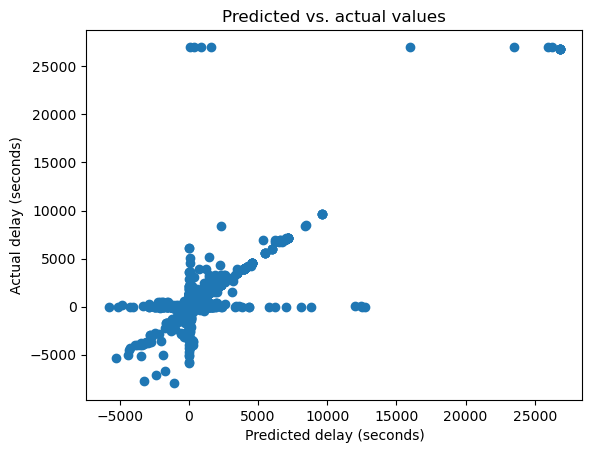

In [17]:
# Plot predicted vs. actual values
plt.scatter(x=y_pred, y=y_val)
plt.title('Predicted vs. actual values')
plt.xlabel('Predicted delay (seconds)')
plt.ylabel('Actual delay (seconds)')
plt.show()

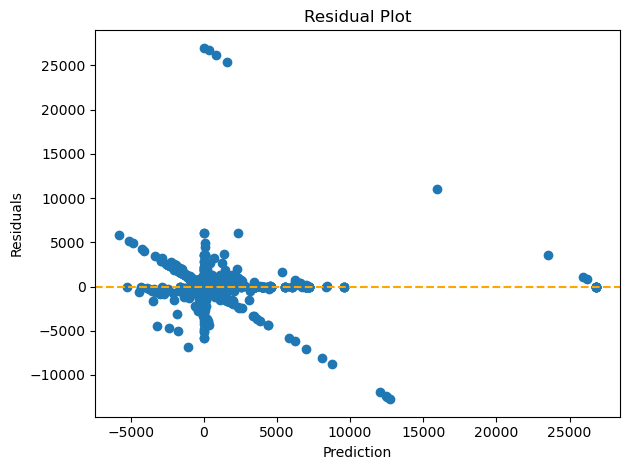

In [18]:
# Plot residuals
residuals = y_val - y_pred
    
plt.scatter(x=y_pred, y=residuals)
plt.title('Residual Plot')
plt.xlabel('Prediction')
plt.ylabel('Residuals')
plt.axhline(0, linestyle="--", color="orange")
plt.tight_layout()
plt.show()

### K-Fold Cross Validation

In [22]:
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
scores = cross_val_score(base_model, X, y, scoring=mse_scorer, cv=5)
rmse_scores = np.sqrt(-scores)
print("Cross-validated RMSE: ", rmse_scores.mean())

KeyboardInterrupt: 

### Feature importances

#### Impurity-based (MDI)

In [23]:
importances = base_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in base_model.estimators_], axis=0)

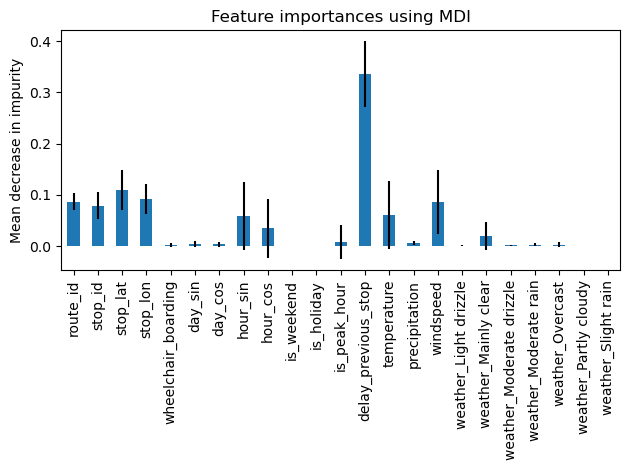

In [25]:
# Plot the impurity-based importance
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title('Feature importances using MDI')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()
plt.show()

#### SHAP Analysis

In [ ]:
# Create SHAP explainer
explainer = shap.Explainer(base_model, X_val)

In [ ]:
# Calculate SHAP values
shap_values = explainer(X_val)

In [ ]:
# Plot a single prediction explanation
shap.plots.waterfall(shap_values[0])

In [ ]:
# Global feature importance
shap.plots.beeswarm(shap_values)

## Fine-tune model

In [ ]:
# Grid Search

## XGBoost Regression

## Final Model

### Evaluation

### Make Prediction

In [ ]:
with open('models/encoders.pickle', 'rb') as handle:
    encoders = pickle.load(handle)

## End